# Generate Dataset Splits for our GSV Dataset

This notebook is the script we run to produce different splits of the data.

In [1]:
%pylab notebook
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys
REPO = os.path.abspath('..')
if REPO not in sys.path:
    sys.path.insert(0, REPO)

In [2]:
import os
from glob import glob
import pandas as pd
import shapely
import shapely.geometry
import tqdm as tq
import sys
import uuid

In [4]:
import annotation
from annotation import Annotation

In [5]:
ROOT = os.path.abspath('../gsv24')   # Data is assumed to be in the repo

In [6]:
xmls = glob(f'{ROOT}/Annotations/**/*.xml', recursive=True)

In [7]:
a = Annotation(xmls[0])

<IPython.core.display.Javascript object>


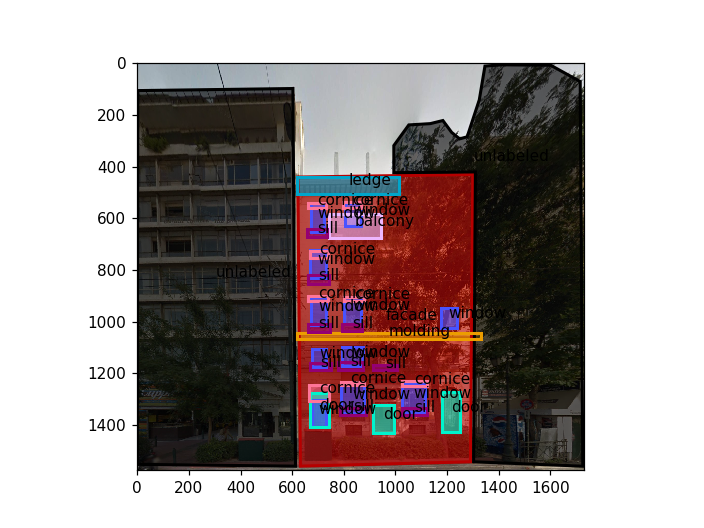

In [8]:
fig = figure()
ax = gca()
a.plot(ax)

 Give everything a safe ID -- one that is not repeated by an object in any other file

_Code in markdown -- should never be run again_
```python
for xml in tq.tqdm_notebook(xmls):
    a = Annotation(xml)
    for o in a.iter_objects():
        o.id = uuid.uuid1().hex
    a.save_annotation()
```

_Confirm that ids are unique_
```python
uids = set()
for xml in tq.tqdm_notebook(xmls):
    a = Annotation(xml)
    for o in a.iter_objects():
        assert o.id not in uids
        uids.add(o.id)
```

In [9]:
obs = {}
finished = set()

In [10]:
for xml in tq.tqdm_notebook(xmls):
    if xml in finished:
        continue
    a = Annotation(xml)
    for o in a.iter_objects():
        if o.deleted: continue
        if o.id in obs: continue  # already done
        pts = a.points(o)
        if np.isnan(pts).any():
            continue
        shape = shapely.geometry.Polygon(pts)
        fields = dict(label=o.name,
                      xml=os.path.relpath(xml, ROOT),
                      img=os.path.relpath(a.image_path, ROOT),
                      xmin = pts[:,0].min(),
                      ymin = pts[:,1].min(), 
                      width = pts[:,0].max() - pts[:,0].min(),
                      height = pts[:,1].max() - pts[:,1].min(),
                      shape = shape
                      )
        obs[o.id] = fields

    finished.add(xml) 

In [11]:
df = pd.DataFrame.from_dict(data=obs, orient='index',
                  columns=['label', 'xml', 'img', 'xmin', 'ymin', 'width', 'height', 'shape'])    

In [27]:
images = {im:randint(5) for im in df.img.unique()}
df['fold'] = [images[im] for im in df.img]

In [12]:
df.label.value_counts()

window                 26062
cornice                12326
sill                   10085
molding                 3050
balcony                 2332
door                    2321
deco                    2311
unlabeled               2115
facade                  2066
obstruction             2025
sign                    1759
pillar                  1645
shop                    1584
ledge                   1405
air-conditioner          960
tree                     877
fire-escape-balcony      586
fire-escape-ladder       546
awning                   522
bay                      161
unknown                  101
flag                      83
sky                       62
roof                       3
Name: label, dtype: int64

In [13]:
df.to_pickle(f'{ROOT}/objects.pkl')

In [23]:
df = pd.read_pickle(f'{ROOT}/objects.pkl')

In [35]:
df.sample()

,label,xml,img,xmin,ymin,width,height,shape,fold
30623b5630a211e99a70613cc4b52a17,window,Annotations/merged/copenhagen_denmark-000771-0...,Images/merged/copenhagen_denmark-000771-000011...,666.0,891.0,25.0,27.0,"POLYGON ((666 891, 691 891, 691 918, 666 918, ...",4
